In [24]:
import sys

sys.path.append("../src")

In [25]:
import geopandas as gpd
import pandas as pd
from geopandas.geodataframe import GeoDataFrame
import matplotlib.pyplot as plt

from config import Config

In [26]:
MONTHS = [
    "Enero",
    "Febrero",
    "Marzo",
    "Abril",
    "Mayo",
    "Junio",
    "Julio",
    "Agosto",
    "Septiembre",
    "Octubre",
    "Noviembre",
    "Diciembre",
]


class TypeOfCrime:
    HOMICIDIO_DOLOSO = "Homicidio doloso"


class Columns:
    SUBTYPE_OF_CRIME = "Subtipo de delito"
    YEAR = "Año"
    CLAVE_ENT = "Clave_Ent"
    ENTIDAD = "Entidad"
    TOTAL = "Total"

In [27]:
data = pd.read_csv(Config.IDFC, encoding="cp1252")
map_: GeoDataFrame = gpd.read_file(Config.MEXICO_SHAPEFILE)


data["Total"] = data[MONTHS].sum(axis=1)
data.head(5)

,Año,Clave_Ent,Entidad,Bien jurídico afectado,Tipo de delito,Subtipo de delito,Modalidad,Enero,Febrero,Marzo,Abril,Mayo,Junio,Julio,Agosto,Septiembre,Octubre,Noviembre,Diciembre,Total
0,2015,1,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Con arma de fuego,3,0,2,1,1,1,2,1,2,2,2.0,1.0,18.0
1,2015,1,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Con arma blanca,1,1,0,0,0,1,0,1,0,0,0.0,1.0,5.0
2,2015,1,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Con otro elemento,0,0,2,2,3,2,0,1,2,0,0.0,0.0,12.0
3,2015,1,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,No especificado,2,0,0,1,0,0,0,0,0,0,0.0,0.0,3.0
4,2015,1,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio culposo,Con arma de fuego,0,0,0,0,1,0,0,0,0,0,0.0,0.0,1.0


In [28]:
# Filtrar por delitos de homicidio doloso
data_filter = data.copy()
data_filter = data_filter[
    data_filter[Columns.SUBTYPE_OF_CRIME] == TypeOfCrime.HOMICIDIO_DOLOSO
]
data_filter.head(5)

# Agrupar por año, clave de entidad y entidad, sumando el total de homicidios dolosos
data_total_hom = data_filter.copy()
data_total_hom = (
    data_total_hom.groupby([Columns.YEAR, Columns.CLAVE_ENT, Columns.ENTIDAD])[
        Columns.TOTAL
    ]
    .sum()
    .reset_index()
)
data_total_hom.head(32)

,Año,Clave_Ent,Entidad,Total
0,2015,1,Aguascalientes,38.0
1,2015,2,Baja California,821.0
2,2015,3,Baja California Sur,151.0
3,2015,4,Campeche,49.0
4,2015,5,Coahuila de Zaragoza,278.0
5,2015,6,Colima,162.0
6,2015,7,Chiapas,502.0
7,2015,8,Chihuahua,945.0
8,2015,9,Ciudad de México,798.0
9,2015,10,Durango,236.0


In [29]:
# Verificar columnas
map_[["CVE_ENT", "NOMGEO"]].dtypes
data_total_hom[[Columns.CLAVE_ENT, Columns.ENTIDAD]].dtypes


Clave_Ent     int64
Entidad      object
dtype: object

In [30]:
# Fix data type mismatch before merge
# Convert both columns to string type to ensure compatibility
map_["CVE_ENT"] = map_["CVE_ENT"].astype(str)
data_total_hom[Columns.CLAVE_ENT] = data_total_hom[Columns.CLAVE_ENT].astype(str)


In [31]:
# Filter for 2024 data
data_2024 = data_total_hom[data_total_hom[Columns.YEAR] == 2024]


In [32]:
map_ = map_.merge(
    data_total_hom[data_total_hom[Columns.YEAR] == 2024],
    left_on=["NOMGEO"],
    right_on=[Columns.ENTIDAD],
    how="left",
)


<Figure size 7500x6000 with 0 Axes>

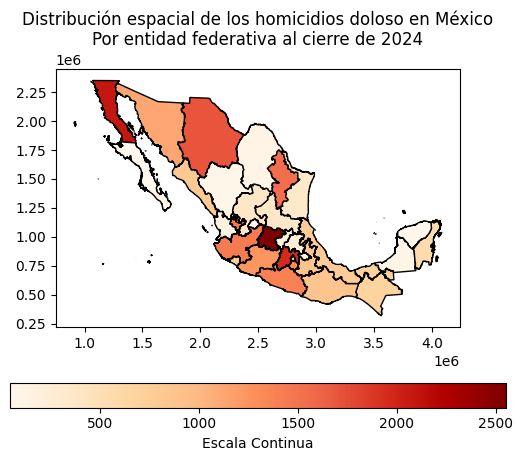

In [33]:
# Mapa temático con variable continua
plt.figure(figsize=(15, 12), dpi=500)
map_.plot(
    column="Total",
    legend=True,
    cmap="OrRd",
    legend_kwds={"label": "Escala Continua", "orientation": "horizontal"},
    edgecolor="black",
)
plt.title(
    "Distribución espacial de los homicidios doloso en México\nPor entidad federativa al cierre de 2024"
)
plt.grid(False)
plt.show()


In [34]:
map_.head(2)

,CVEGEO,CVE_ENT,NOMGEO,geometry,Año,Clave_Ent,Entidad,Total
0,01,01,Aguascalientes,"POLYGON ((2469550.852 1159302.643, 2469738.209...",2024,1,Aguascalientes,112.0
1,02,02,Baja California,"MULTIPOLYGON (((1313480.513 1831458.607, 13135...",2024,2,Baja California,2089.0
